In [1]:
# Imporing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

Task 1.
# Loading and Exploring the Dataset:
The first task is to load the dataset containing historical ride data. Take a look at the structure of the data, examine the features, and gain insights into the variables that may influence the fare amount. 

In [2]:
#Loading dataset
df = pd.read_csv('uber.csv')

## Exploring the data

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [5]:
df.shape

(200000, 9)

Task 2 
# Handling Missing Data

In [6]:
# checking for null values
df.isna().sum().sort_values(ascending=False)

dropoff_longitude    1
dropoff_latitude     1
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
passenger_count      0
dtype: int64

In [7]:
# As there are only 2 rows with null value so droping them will not effect our analysis
df=df.dropna()

In [8]:
df.shape

(199999, 9)

In [9]:
df.isna().sum().sum()

0

In [10]:
# Exploring the column fare_amount
df['fare_amount'].describe()

count    199999.000000
mean         11.359892
std           9.901760
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [11]:
# The minimum value of -52.00 suggests there may be outliers or data entry errors in the dataset, as fares are generally non-negative. 

In [12]:
# Making all fare amounts positive
df['fare_amount'] = df['fare_amount'].abs()

In [13]:
df['fare_amount'].describe()

count    199999.000000
mean         11.362780
std           9.898445
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

## Handling Outliers

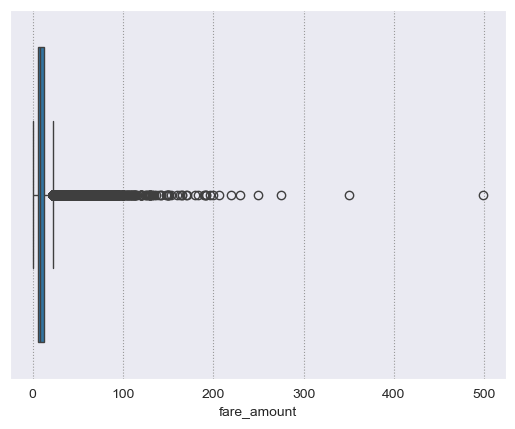

In [14]:
# checking for outliers in the dataset
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

In [15]:
# using IQR Method for Outliers
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

In [16]:
df.shape

(182839, 9)

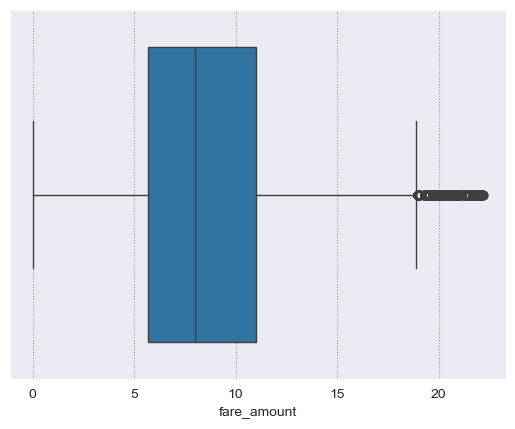

In [17]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

Task 3 
# Feature Engineering

In [18]:
# Longitude and lattitude should be in range [-90,90]
df = df[(df['pickup_latitude']  >= -90) & (df['pickup_latitude'] <= 90)]

In [19]:
df = df[(df['dropoff_latitude']  >= -90) & (df['dropoff_latitude'] <= 90)]

In [20]:
df.shape

(182834, 9)

In [21]:
# calculating the haversine distance between pickup and drop-off points
from geopy.distance import geodesic
import pandas as pd

# Defining the function to calculate distance
def calculate_distance(row):
    try:
        pickup = (row['pickup_latitude'], row['pickup_longitude'])
        dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
        return geodesic(pickup, dropoff).kilometers
    except Exception as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # Return None for rows with errors

# Checking for missing data in critical columns
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# Appling the function and calculate distance
df['distance_km'] = df.apply(calculate_distance, axis=1)

In [22]:
# Convert pickup_datetime to datetime if not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Check for any invalid conversions
if df['pickup_datetime'].isnull().any():
    print("Some values in 'pickup_datetime' could not be converted to datetime format. Check for invalid entries.")

# Now extract hour of day
df['hour'] = df['pickup_datetime'].dt.hour

# Time of Day (morning, afternoon, evening, night)
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

# Day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Month
df['month'] = df['pickup_datetime'].dt.month

In [23]:
# Creating a binary feature to indicate if the ride happened during rush hours (e.g., 7–9 AM and 4–7 PM). Fares may be higher during these periods.
def is_rush_hour(hour):
    return 1 if (7 <= hour <= 9) or (16 <= hour <= 19) else 0

df['rush_hour'] = df['hour'].apply(is_rush_hour)

In [24]:
# Creating a binary indicator for whether the trip occurred on a holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())
df['holiday'] = df['pickup_datetime'].dt.date.isin(holidays.date).astype(int)

In [25]:
# Create a binary feature indicating whether the ride occurred on a weekend
df['weekend'] = df['pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [26]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,time_of_day,day_of_week,month,rush_hour,holiday,weekend
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.681111,19,evening,3,5,1,0,0
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.454363,20,evening,4,7,0,0,0
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.039603,21,evening,0,8,0,0,0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661442,8,morning,4,6,1,0,0
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.483730,17,evening,3,8,1,0,0


In [27]:
df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance_km', 'hour',
       'time_of_day', 'day_of_week', 'month', 'rush_hour', 'holiday',
       'weekend'],
      dtype='object')

In [28]:
#  Removing Irrelavant columns "id","key","pickup_datetime"
df.drop(["Unnamed: 0","key","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_latitude","dropoff_longitude"], axis=1, inplace=True)

In [29]:
# Exploring new columns
df.head()

,fare_amount,passenger_count,distance_km,hour,time_of_day,day_of_week,month,rush_hour,holiday,weekend
0,7.5,1,1.681111,19,evening,3,5,1,0,0
1,7.7,1,2.454363,20,evening,4,7,0,0,0
2,12.9,1,5.039603,21,evening,0,8,0,0,0
3,5.3,3,1.661442,8,morning,4,6,1,0,0
4,16.0,5,4.483730,17,evening,3,8,1,0,0


In [30]:
#  Checking if distance in negative
df["distance_km"].describe()

count    182834.000000
mean         18.029294
std         358.254136
min           0.000000
25%           1.162919
50%           1.961169
75%           3.281968
max        8783.593498
Name: distance_km, dtype: float64

* min 0 suggest there are no negative values

Task 4
# EDA

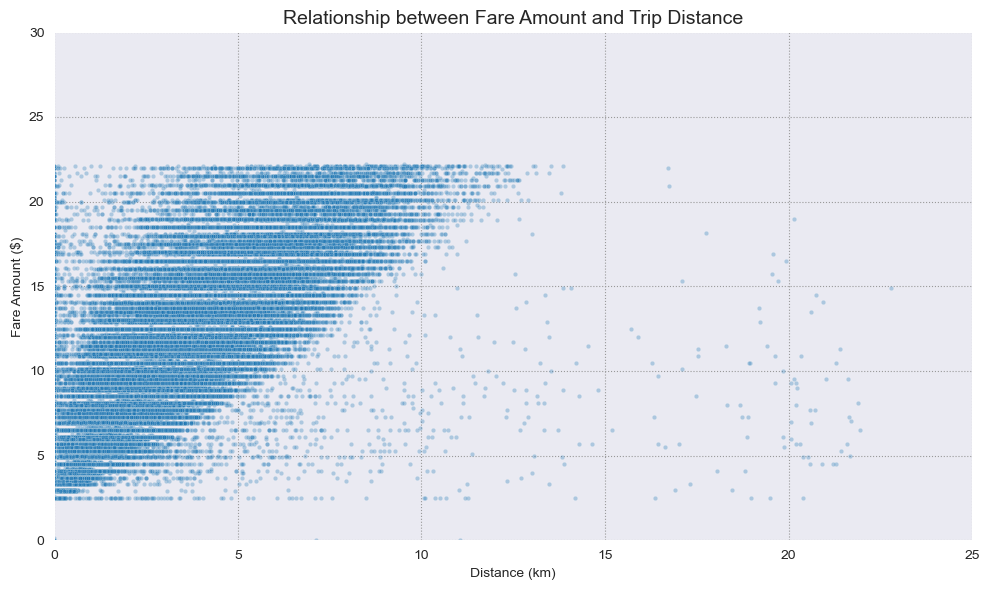

In [31]:
# Relation Between fare and distance
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="distance_km", 
    y="fare_amount", 
    data=df, 
    alpha=0.3, 
    s=10
)
plt.xlim(0, 25)
plt.ylim(0, 30)
plt.title("Relationship between Fare Amount and Trip Distance", fontsize=14)
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.tight_layout()
plt.show()

* There's a clear positive correlation: as distance increases, fare increases. Most trips are within 0–10 km and $0–30.

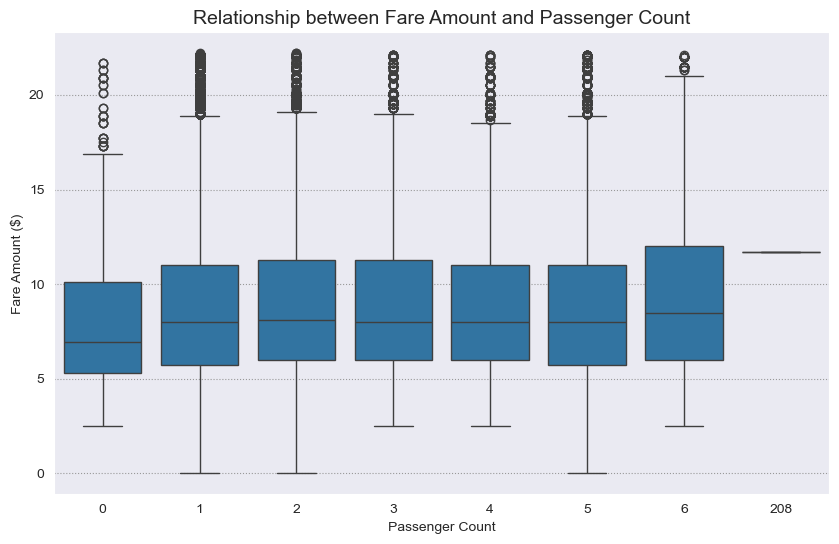

In [32]:
# Relation Between fare and passanger count
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="passenger_count", 
    y="fare_amount", 
    data=df,
)
plt.title("Relationship between Fare Amount and Passenger Count", fontsize=14)
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.show()

* Most passenger counts are between 1 and 3.

* Median fare is fairly consistent across passenger counts.

* Outliers exist, especially for smaller groups — possibly due to longer or premium trips.

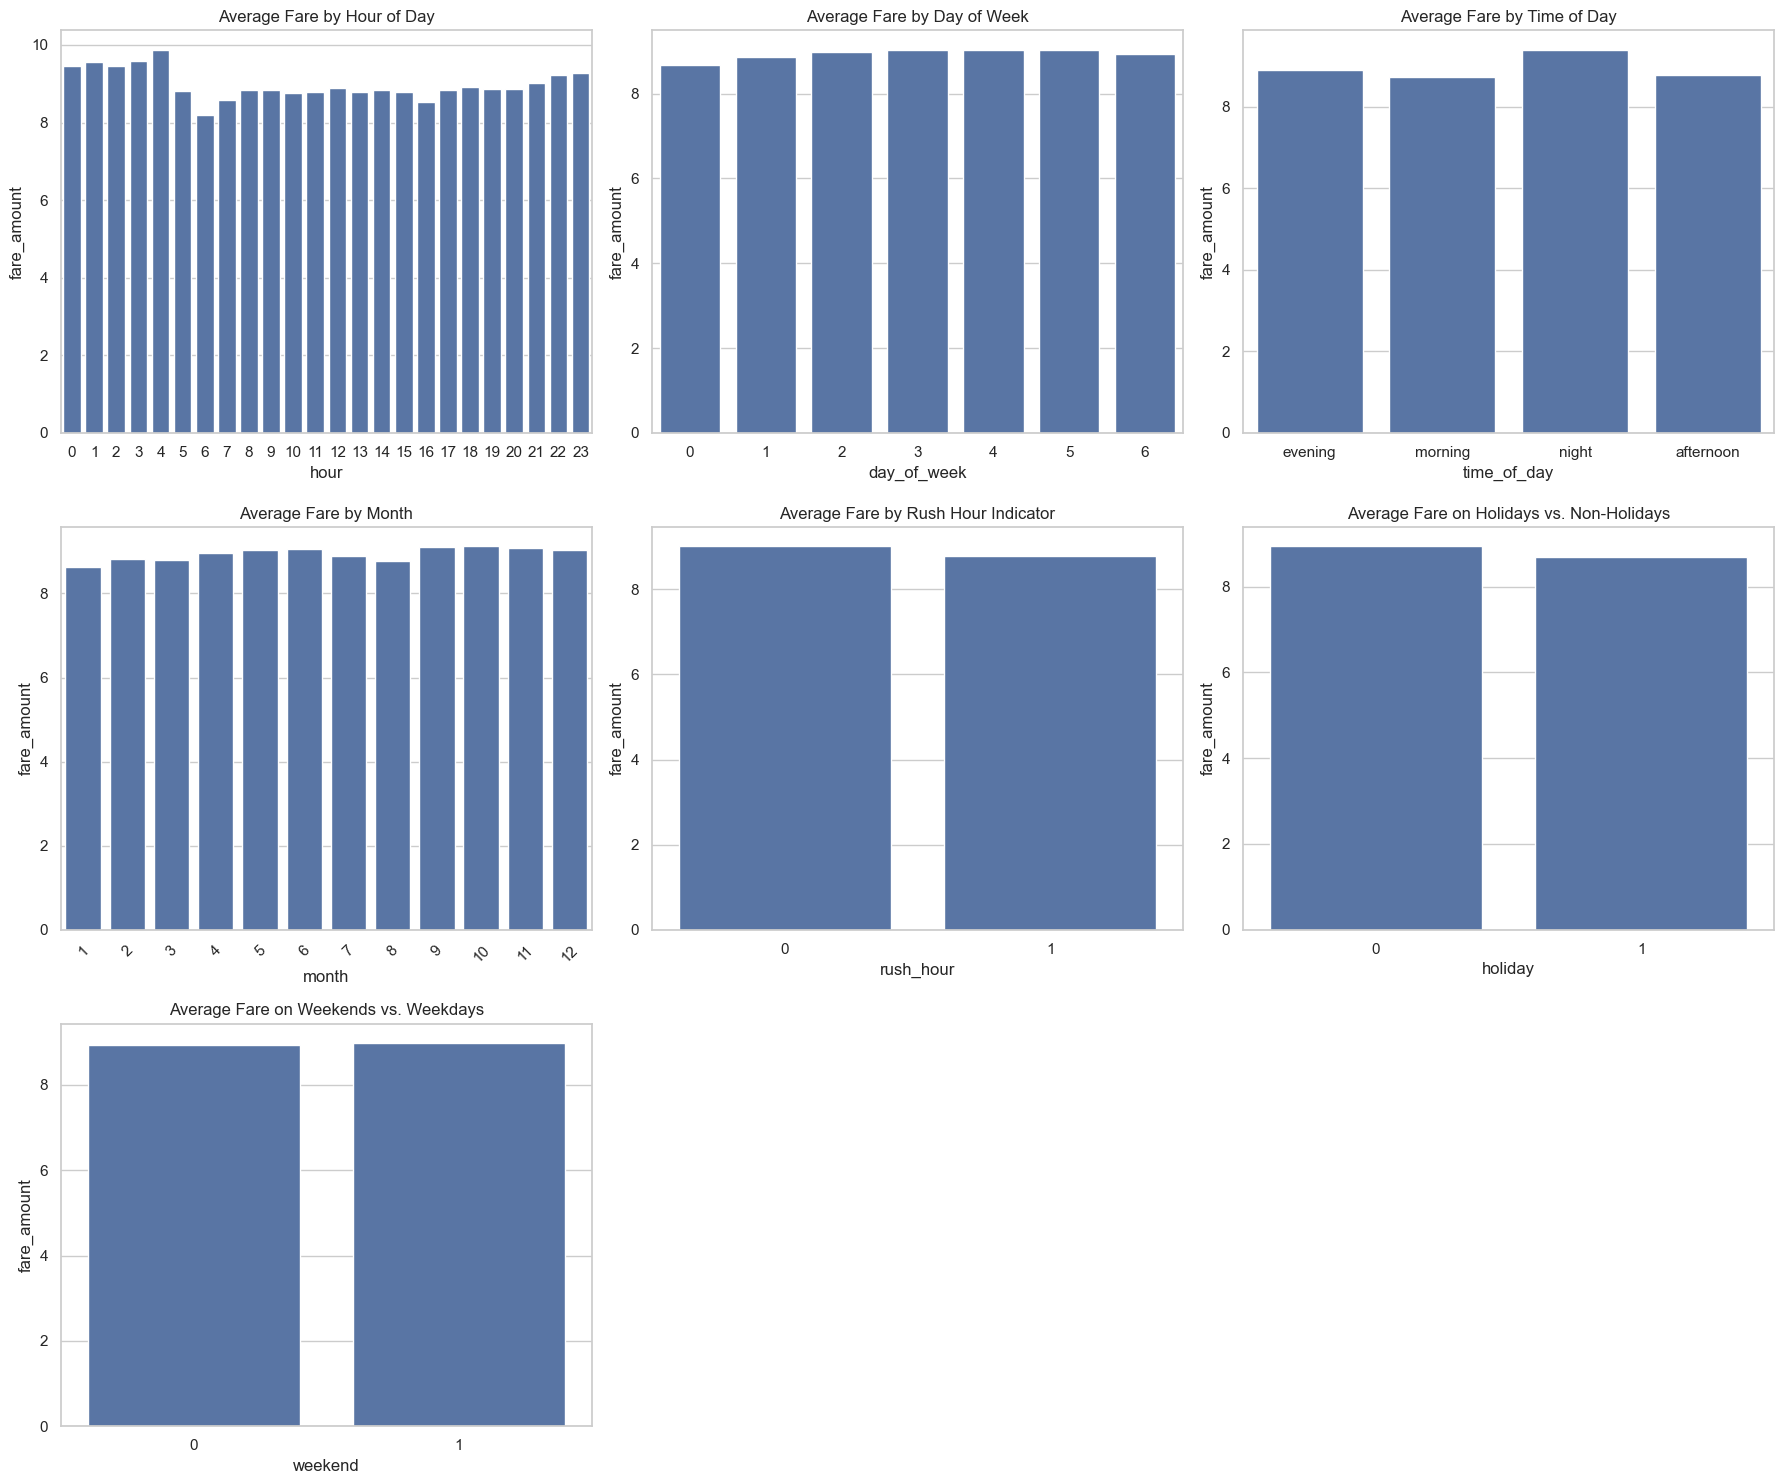

In [33]:
# Trends over time
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot 1: Hour of Day
sns.barplot(ax=axes[0], x="hour", y="fare_amount", data=df, ci=None)
axes[0].set_title("Average Fare by Hour of Day")

# Plot 2: Day of Week (ordered)
sns.barplot(ax=axes[1], x="day_of_week", y="fare_amount", data=df, ci=None)
axes[1].set_title("Average Fare by Day of Week")

# Plot 3: Time of Day
sns.barplot(ax=axes[2], x="time_of_day", y="fare_amount", data=df, ci=None)
axes[2].set_title("Average Fare by Time of Day")

# Plot 4: Month (ordered)
sns.barplot(ax=axes[3], x="month", y="fare_amount", data=df, ci=None)
axes[3].set_title("Average Fare by Month")
axes[3].tick_params(axis='x', rotation=45)

# Plot 5: Rush Hour
sns.barplot(ax=axes[4], x="rush_hour", y="fare_amount", data=df, ci=None)
axes[4].set_title("Average Fare by Rush Hour Indicator")

# Plot 6: Holiday
sns.barplot(ax=axes[5], x="holiday", y="fare_amount", data=df, ci=None)
axes[5].set_title("Average Fare on Holidays vs. Non-Holidays")

# Plot 7: Weekend
sns.barplot(ax=axes[6], x="weekend", y="fare_amount", data=df, ci=None)
axes[6].set_title("Average Fare on Weekends vs. Weekdays")

# Remove unused subplots if necessary
for i in range(7, 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Task 5 
# Data Preparation

## Encodimg categorical features

In [34]:
# One-Hot Encode 'day_of_week' and 'time_of_day' to convert categories into binary columns
# 'drop_first=True' avoids dummy variable trap (drops the first category to prevent multicollinearity)
df = pd.get_dummies(df, columns=["day_of_week", "time_of_day"], drop_first=True)

# Encode the 'hour' feature as cyclical using sine and cosine to preserve time proximity (e.g., 23 ~ 0)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Maps 0–23 to sine wave
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  # Maps 0–23 to cosine wave

# Encode the 'month' feature cyclically to capture seasonal patterns
df['month_sin'] = np.sin(2 * np.pi * df['month']/ 12)  # Maps 1–12 to sine wave
df['month_cos'] = np.cos(2 * np.pi * df['month']/ 12)  # Maps 1–12 to cosine wave

In [35]:
df.head()

,fare_amount,passenger_count,distance_km,hour,month,rush_hour,holiday,weekend,day_of_week_1,day_of_week_2,...,day_of_week_4,day_of_week_5,day_of_week_6,time_of_day_evening,time_of_day_morning,time_of_day_night,hour_sin,hour_cos,month_sin,month_cos
0,7.5,1,1.681111,19,5,1,0,0,False,False,...,False,False,False,True,False,False,-0.965926,0.258819,5.000000e-01,-0.866025
1,7.7,1,2.454363,20,7,0,0,0,False,False,...,True,False,False,True,False,False,-0.866025,0.500000,-5.000000e-01,-0.866025
2,12.9,1,5.039603,21,8,0,0,0,False,False,...,False,False,False,True,False,False,-0.707107,0.707107,-8.660254e-01,-0.500000
3,5.3,3,1.661442,8,6,1,0,0,False,False,...,True,False,False,False,True,False,0.866025,-0.500000,1.224647e-16,-1.000000
4,16.0,5,4.483730,17,8,1,0,0,False,False,...,False,False,False,True,False,False,-0.965926,-0.258819,-8.660254e-01,-0.500000


## Scaling/normalizing The Data Using Standard Scaler method

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cols = ['distance_km','passenger_count']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

## splitting the data into training and test datasets

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop("fare_amount", axis=1)
y = df["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,passenger_count,distance_km,hour,month,rush_hour,holiday,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,time_of_day_evening,time_of_day_morning,time_of_day_night,hour_sin,hour_cos,month_sin,month_cos
62249,-0.489622,-0.047760,23,1,0,0,0,False,False,True,False,False,False,False,False,True,-0.258819,0.965926,0.500000,0.866025
85265,0.228891,-0.040989,8,2,1,0,0,True,False,False,False,False,False,False,True,False,0.866025,-0.500000,0.866025,0.500000
193595,2.384432,-0.040875,19,8,1,0,0,False,False,True,False,False,False,True,False,False,-0.965926,0.258819,-0.866025,-0.500000
151906,-0.489622,-0.045524,16,8,1,0,0,True,False,False,False,False,False,False,False,False,-0.866025,-0.500000,-0.866025,-0.500000
145708,-0.489622,-0.043059,11,10,0,0,0,False,False,False,True,False,False,False,True,False,0.258819,-0.965926,-0.866025,0.500000


Task 7 
# Select and train the Regression Model

## Train and compare the Regression Models

In [38]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Model selection & evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Dictionary to store models and their performance
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=42),
    "Random Forest Regression": RandomForestRegressor(random_state=42, n_estimators=100),
}

# Train each model and evaluate on the test set
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2}
    
    print(f"\n{model_name}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

# Optional: Display all model performance results
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['Mean Squared Error']}, R^2 = {metrics['R^2 Score']}")


Linear Regression
Mean Squared Error: 17.168619043150258
R^2 Score: 0.004016323478717609

Decision Tree Regression
Mean Squared Error: 11.074568626358804
R^2 Score: 0.3575435771132246

Random Forest Regression
Mean Squared Error: 5.9719097473946485
R^2 Score: 0.653558354861602

Model Performance Summary:
Linear Regression: MSE = 17.168619043150258, R^2 = 0.004016323478717609
Decision Tree Regression: MSE = 11.074568626358804, R^2 = 0.3575435771132246
Random Forest Regression: MSE = 5.9719097473946485, R^2 = 0.653558354861602


 Here's a brief analysis of the results:
Three regression models were evaluated to predict Uber fares using structured features:

 *   Linear Regression performed poorly, with an R² score of 0.004, indicating it explained almost none of the variance in fare prices. This suggests a linear model is too simplistic for the problem.
*
    Decision Tree Regression showed moderate improvement, achieving an R² of 0.36, capturing some non-linear relationships, but likely overfitting to specific patterns.*

    Random Forest Regression outperformed the others with an R² of 0.65 and the lowest MSE (5.97), demonstrating strong predictive power and generalization ability across complex feature interactions.

🔎 Conclusion: Random Forest is currently the most suitable model. Further improvements could be achieved with advanced models like XGBoost or hyperparameter tuning.

## Trying XGBoost

In [39]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error, r2_score
print("XGBoost MSE:", mean_squared_error(y_test, y_pred))
print("XGBoost R²:", r2_score(y_test, y_pred))

XGBoost MSE: 5.438227619485054
XGBoost R²: 0.6845182524813914


* R² Score of 0.68 indicates that XGBoost explains 68% of the variance in the Uber fare data, which is a strong result. This is better than the Random Forest model's R² of 0.65.
* 
MSE of 5.44 shows that XGBoost's predictions are relatively accurate, with smaller errors compared to the other models.

In [41]:
from sklearn.model_selection import RandomizedSearchCV
# Define the model
xgb_model = XGBRegressor(random_state=42)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,             # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,                  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Get best model and performance
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate on test data
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Optimized XGBoost MSE:", mse)
print("Optimized XGBoost R²:", r2)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Optimized XGBoost MSE: 5.341645971788217
Optimized XGBoost R²: 0.6901211343623286


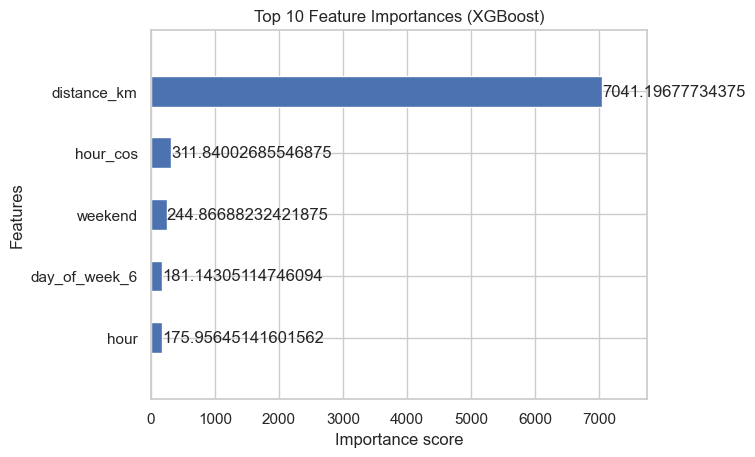

In [44]:
from xgboost import plot_importance
plot_importance(best_xgb, max_num_features=5, importance_type='gain', height=0.5)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Use your best parameters from RandomizedSearchCV
final_model = XGBRegressor(
    subsample=0.6,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    random_state=42
)

# Perform 5-fold cross-validation on the full dataset
scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')

print("Cross-Validated R² Scores:", scores)
print("Mean R² Score:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validated R² Scores: [0.68430253 0.69260797 0.69342003 0.68112599 0.68601844]
Mean R² Score: 0.6874949920929586
Standard Deviation: 0.004778801969267531


* Mean R² Score: 0.6875
This aligns very closely with your earlier test set R² (~0.6901), confirming that your model performs consistently on unseen data.* 

Standard Deviation: 0.0048
This is very low, which means the model’s performance is highly stable across different data splits. 

In [46]:
import pickle

# Suppose `final_model` is your trained XGBoost model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Model saved successfully.")

Model saved successfully.


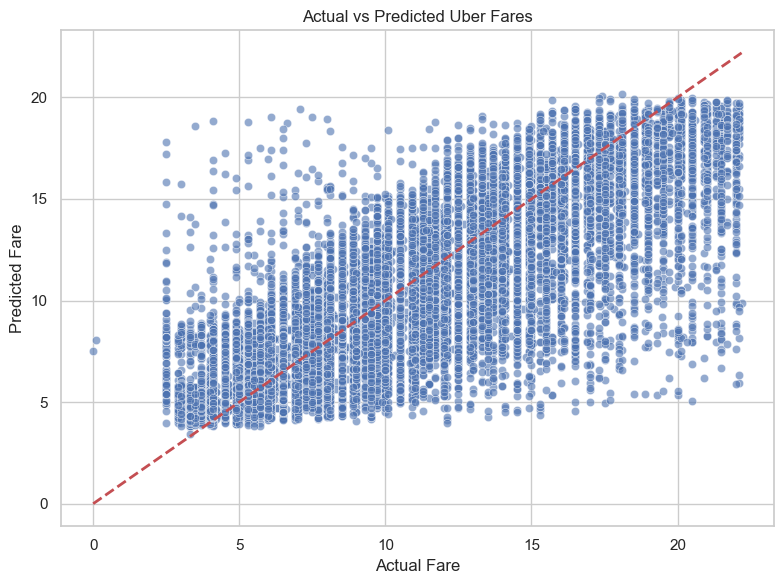

In [47]:
# Assume y_test and y_pred are your true and predicted fare values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs Predicted Uber Fares')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights Training and testing metrics are close, showing the model generalizes well. High R² score and low MSE/ MAE suggest a good fit.